In [5]:
from ultralytics import YOLO
from ultralytics.data.dataset import YOLODataset
import torch
import cv2
import matplotlib.pyplot as plt
import re, os, random
import tqdm
import logging

In [6]:
# dataset_path = 'D:\\UGM\\tugas akhir\\3. skripsi\\code\\datasets'
dataset_path = 'D:\\UGM\\tugas akhir\\datasets\\KITTI2017'

model = YOLO("yolo11n-dist.yaml")
# load pretrained weights
model.load(weights="../weights/yolo11n-dist_2025-12-19-05_final_z_ep100.pt")

# use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

Transferred 524/524 items from pretrained weights


YOLO(
  (model): DistModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats

## Helper Functions

In [7]:
def box_iou_xyxy(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    inter_w = max(0, xB - xA)
    inter_h = max(0, yB - yA)
    inter = inter_w * inter_h

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = area1 + area2 - inter + 1e-6
    return inter / union

# Greedy IoU matching
# boxes in xyxy format
def match_predictions_to_gt(
    pred_boxes, pred_classes,
    gt_boxes, gt_classes,
    iou_thresh=0.5
):
    matches = []
    used_gt = set()

    for pi, (pbox, pcls) in enumerate(zip(pred_boxes, pred_classes)):
        best_iou = 0
        best_gi = -1

        # find best gt match for this prediction
        for gi, (gbox, gcls) in enumerate(zip(gt_boxes, gt_classes)):
            if gi in used_gt:
                continue
            if pcls != gcls:
                continue

            iou = box_iou_xyxy(pbox, gbox)
            if iou > best_iou:
                best_iou = iou
                best_gi = gi

        if best_iou >= iou_thresh:
            matches.append((pi, best_gi, best_iou))
            used_gt.add(best_gi) # make sure this gt is only used once

    unmatched_preds = list(set(range(len(pred_boxes))) - {m[0] for m in matches})
    unmatched_gts = list(set(range(len(gt_boxes))) - used_gt)

    return matches, unmatched_preds, unmatched_gts

In [18]:
def draw_box(ax, box, label=None, color="lime", linestyle="-"):
    x1, y1, x2, y2 = box
    w = x2 - x1
    h = y2 - y1
    rect = plt.Rectangle(
        (x1, y1),
        w, h,
        linewidth=1.5,
        edgecolor=color,
        facecolor="none",
        linestyle=linestyle
    )
    ax.add_patch(rect)

    if label is not None and type(label) == str:
        ax.text(
            x1 + 5, y1 - 10,
            label, color="black", fontsize=9,
            bbox=dict(facecolor=color, alpha=0.7, edgecolor="none"),
        )

def show_inference(image_path, conf_thresh = 0.5, iou_thresh = 0.5, show_gt_dist = True, euclidean_dist = False):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print("Error: Unable to read image.")
        return

    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_width = img.shape[1]
    img_height = img.shape[0]

    # run inference and get prediction result
    result = model.predict(img_bgr, conf=conf_thresh)[0]
    class_names = result.names

    boxes = result.boxes.xywh.cpu().numpy()
    scores = result.boxes.conf.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy()
    distances = result.distances.cpu().numpy()

    pred_boxes = []
    pred_classes = []
    pred_scores = []
    pred_distances = []
    gt_boxes = []
    gt_classes = []
    gt_distances = []

    for (cx, cy, w, h), score, cls, dist in zip(boxes, scores, classes, distances):
        # reformat pred boxes from xywh to xyxy
        pred_boxes.append([
            float(cx - w/2), float(cy - h/2),
            float(cx + w/2), float(cy + h/2)
        ])
        pred_classes.append(int(cls))
        pred_scores.append(float(score))
        pred_distances.append(float(dist))

    # replace /images/ with /labels/ and .png to .txt
    label_path = re.sub(r"(/|\\)images(/|\\)", r"\1labels\2", image_path)
    label_path = re.sub(r"\.(jpg|png)", ".txt", label_path, flags=re.IGNORECASE)
    is_label_found = False
    
    # load ground truth label
    if os.path.isfile(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, cx, cy, bw, bh, dx, dy, dz = map(float, line.strip().split())
                # convert normalized xywh to pixel xyxy
                cx *= img_width
                cy *= img_height
                bw *= img_width
                bh *= img_height
                gt_boxes.append((
                    (cx - bw/2), (cy - bh/2),
                    (cx + bw/2), (cy + bh/2)
                ))
                gt_classes.append(int(cls))
                if euclidean_dist:
                    euc_dist = torch.linalg.vector_norm(torch.tensor([dx, dy, dz]), ord=2).item()
                    gt_distances.append(float(euc_dist))
                else:
                    gt_distances.append(float(dz))

        is_label_found = True
    else:
        print(f"[WARNING] Label not found: {label_path}")

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    ax.axis("off")

    if not is_label_found:
        print("Num of predictions:", len(pred_boxes))

        # draw only predictions if no gt available
        for pi, pbox in enumerate(pred_boxes):
            cls = class_names[pred_classes[pi]]
            label = ""
            label += f"{cls}" # class name
            label += f" {pred_scores[pi]:.2f}" # confidence score
            label += f" {pred_distances[pi]:.1f}m" # distance

            draw_box(ax, pbox, label=label, color="lime")

        plt.tight_layout()
        plt.show()
        return
    
    matches, fp_preds, fn_gts = match_predictions_to_gt(
        pred_boxes, pred_classes,
        gt_boxes, gt_classes,
        iou_thresh=iou_thresh
    )

    print("\nImage path:", image_path)
    print("Num of predictions:", len(pred_boxes))
    print("Num of ground truth:", len(gt_boxes))

    # true positives / matches
    for pi, gi, iou in matches:
        cls = class_names[pred_classes[pi]]
        pred_dist = pred_distances[pi]
        gt_dist = gt_distances[gi]
        dist_rel_err = abs(pred_dist - gt_dist) / (gt_dist + 1e-6) * 100.0
        label = ""
        label += f"{cls}" # class name
        # label += f" {pred_scores[pi]:.2f}" # confidence score
        if show_gt_dist:
            label += f" {pred_dist:.1f}/{gt_dist:.1f}" # distance pred compared to gt
        else:
            label += f" {pred_dist:.1f}m" # distance

        # draw both boxes to compare
        draw_box(ax, pred_boxes[pi], label=label, color="lime")
        draw_box(ax, gt_boxes[gi], color="lime", linestyle="--")
        print(f"[TP] Pred {pi} <-> GT {gi} | IoU: {iou:.3f} | {cls} | Dist: {pred_dist:.1f}/{gt_dist:.1f} ({dist_rel_err:.1f}%)")

    # false postives / only in predictions
    for pi in fp_preds:
        cls = class_names[pred_classes[pi]]
        label = ""
        label += f"{cls}" # class name
        # label += f" {pred_scores[pi]:.2f}" # confidence score
        label += f" {pred_distances[pi]:.1f}m" # distance

        draw_box(ax, pred_boxes[pi], label=label, color="yellow")
        print(f"[FP] Pred {pi} | {cls}")

    # false negatives / only in ground truths
    for gi in fn_gts:
        cls = class_names[gt_classes[gi]]

        draw_box(ax, gt_boxes[gi], color="red", linestyle="--")
        print(f"[FN] GT {gi} | {cls}")

    plt.tight_layout()
    plt.show()

    print("=======================================================================\n")

## Model Mistakes Evaluation

In [19]:
val_dataset_path = "D:\\UGM\\tugas akhir\\datasets\\KITTI2017\\images\\val"

val_dataset = YOLODataset(
    img_path = val_dataset_path,
    augment = False,
    data = { 'nc': 7 }
)

Fast image access  (ping: 0.00.0 ms, read: 808.9587.8 MB/s, size: 818.4 KB)
Scanning D:\UGM\tugas akhir\datasets\KITTI2017\labels\val.cache... 1496 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1496/1496  0.0s


In [20]:
IOU_THRESHOLD = 0.5
MAX_IMAGES = 50  # set to 0 to process all images

# to reduce logging output when doing model.predict()
logging.getLogger("ultralytics").setLevel(logging.WARNING)

fp_files = []
fn_files = []
tp_count = 0
fp_count = 0
fn_count = 0

# randomize image selection
sample_list = random.sample(range(val_dataset.ni), MAX_IMAGES) if MAX_IMAGES > 0 else range(val_dataset.ni)

for i in tqdm.tqdm(sample_list, desc="Loading images"):
    label = val_dataset.get_image_and_label(i)
    result = model.predict(label["img"])[0]

    boxes = result.boxes.xywh.cpu().numpy()
    classes = result.boxes.cls.cpu().numpy()

    pred_boxes = []
    pred_classes = []
    gt_boxes = []
    gt_classes = []

    for (cx, cy, w, h), cls in zip(boxes, classes):
        # reformat pred boxes from xywh to xyxy
        pred_boxes.append([
            float(cx - w/2), float(cy - h/2),
            float(cx + w/2), float(cy + h/2)
        ])
        pred_classes.append(int(cls))

    img_shape = label["resized_shape"]
    label["instances"].convert_bbox("xyxy") # convert gt boxes from xywh to xyxy
    for box, cls in zip(label["instances"].bboxes, label["cls"]):
        gt_boxes.append([
            # denormalize box coordinates
            float(box[0] * img_shape[1]), float(box[1] * img_shape[0]),
            float(box[2] * img_shape[1]), float(box[3] * img_shape[0])
        ])
        gt_classes.append(int(cls.item()))

    # get TP, FP, FN
    matches, fp_preds, fn_gts = match_predictions_to_gt(
        pred_boxes, pred_classes,
        gt_boxes, gt_classes,
        iou_thresh=IOU_THRESHOLD
    )

    if len(fp_preds) > 0:
        fp_files.append((val_dataset.im_files[i], len(matches), len(fp_preds), len(fn_gts)))
    if len(fn_gts) > 0:
        fn_files.append((val_dataset.im_files[i], len(matches), len(fp_preds), len(fn_gts)))

    tp_count += len(matches)
    fp_count += len(fp_preds)
    fn_count += len(fn_gts)

# reset logging level back to info
logging.getLogger("ultralytics").setLevel(logging.INFO)

total_objects = tp_count + fp_count + fn_count
print(f"\nTotal objects: {total_objects} from {len(sample_list)} images")
print(f"Total True Positives (TP): {tp_count} ({tp_count/total_objects*100:.2f}%)")
print(f"Total False Positives (FP): {fp_count} ({fp_count/total_objects*100:.2f}%)")
print(f"Total False Negatives (FN): {fn_count} ({fn_count/total_objects*100:.2f}%)")

print("\nFiles with False Positives (FP):")
for file_path, tp, fp, fn in fp_files:
    print(f"{file_path}: TP={tp:<3} FP={fp:<3} FN={fn:<3}")

print("\nFiles with False Negatives (FN):")
for file_path, tp, fp, fn in fn_files:
    print(f"{file_path}: TP={tp:<3} FP={fp:<3} FN={fn:<3}")

Loading images: 100%|██████████| 50/50 [00:02<00:00, 22.18it/s]


Total objects: 273 from 50 images
Total True Positives (TP): 230 (84.25%)
Total False Positives (FP): 23 (8.42%)
Total False Negatives (FN): 20 (7.33%)

Files with False Positives (FP):
D:\UGM\tugas akhir\datasets\KITTI2017\images\val\006328.png: TP=7   FP=2   FN=1  
D:\UGM\tugas akhir\datasets\KITTI2017\images\val\007034.png: TP=5   FP=3   FN=0  
D:\UGM\tugas akhir\datasets\KITTI2017\images\val\006424.png: TP=10  FP=3   FN=2  
D:\UGM\tugas akhir\datasets\KITTI2017\images\val\006639.png: TP=14  FP=1   FN=0  
D:\UGM\tugas akhir\datasets\KITTI2017\images\val\006689.png: TP=6   FP=1   FN=0  
D:\UGM\tugas akhir\datasets\KITTI2017\images\val\006488.png: TP=10  FP=3   FN=0  
D:\UGM\tugas akhir\datasets\KITTI2017\images\val\006997.png: TP=5   FP=3   FN=0  
D:\UGM\tugas akhir\datasets\KITTI2017\images\val\007077.png: TP=1   FP=1   FN=1  
D:\UGM\tugas akhir\datasets\KITTI2017\images\val\006256.png: TP=9   FP=1   FN=3  
D:\UGM\tugas akhir\datasets\KITTI2017\images\val\006950.png: TP=7   FP=1   

You can copy paste the file path to "Compare Prediction vs Ground Truth" section to analyze the mistake

## Compare Prediction vs Ground Truth

__Boxes category__
* __Green:__ TP prediction
* __Green dashed:__ TP ground truth
* __Yellow:__ FP prediction
* __Red dashed:__ FN ground truth

0: 224x640 6 1s, 1 2, 1 5, 31.0ms
Speed: 2.0ms preprocess, 31.0ms inference, 21.0ms postprocess per image at shape (1, 3, 224, 640)

Image path: D:\UGM\tugas akhir\datasets\KITTI2017/images/train/000021.png
Num of predictions: 8
Num of ground truth: 8
[TP] Pred 0 <-> GT 3 | IoU: 0.982 | 2 | Dist: 19.5/21.3 (8.4%)
[TP] Pred 1 <-> GT 1 | IoU: 0.979 | 1 | Dist: 13.4/13.3 (0.9%)
[TP] Pred 2 <-> GT 0 | IoU: 0.958 | 5 | Dist: 3.2/3.1 (2.8%)
[TP] Pred 3 <-> GT 2 | IoU: 0.976 | 1 | Dist: 17.1/17.6 (2.8%)
[TP] Pred 4 <-> GT 4 | IoU: 0.956 | 1 | Dist: 26.4/26.0 (1.6%)
[TP] Pred 5 <-> GT 5 | IoU: 0.955 | 1 | Dist: 25.2/26.8 (6.1%)
[TP] Pred 6 <-> GT 6 | IoU: 0.947 | 1 | Dist: 30.0/32.1 (6.8%)
[TP] Pred 7 <-> GT 7 | IoU: 0.935 | 1 | Dist: 31.1/31.8 (2.2%)


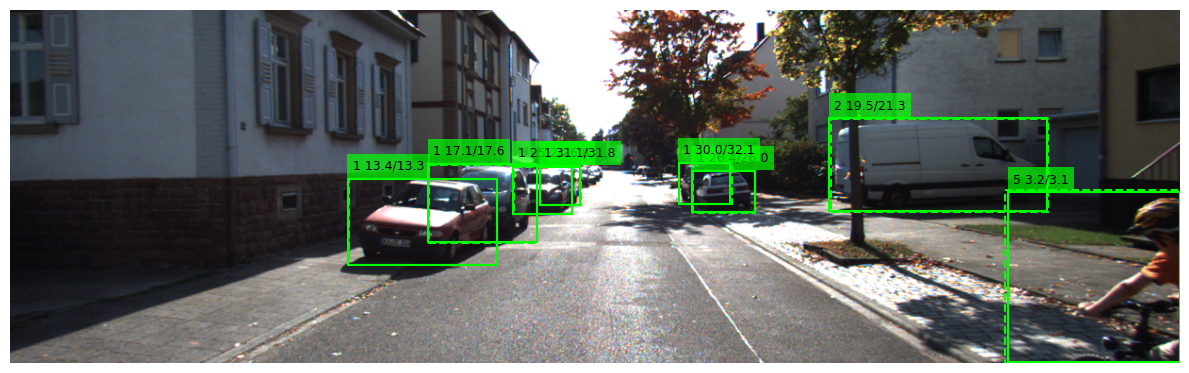



0: 224x640 10 1s, 4 2s, 1 3, 21.2ms
Speed: 2.2ms preprocess, 21.2ms inference, 15.5ms postprocess per image at shape (1, 3, 224, 640)

Image path: D:\UGM\tugas akhir\datasets\KITTI2017/images/train/000113.png
Num of predictions: 15
Num of ground truth: 15
[TP] Pred 0 <-> GT 1 | IoU: 0.988 | 1 | Dist: 6.6/7.1 (7.0%)
[TP] Pred 1 <-> GT 5 | IoU: 0.957 | 1 | Dist: 26.2/25.4 (3.2%)
[TP] Pred 2 <-> GT 13 | IoU: 0.971 | 1 | Dist: 26.1/25.3 (3.1%)
[TP] Pred 3 <-> GT 3 | IoU: 0.980 | 2 | Dist: 21.0/21.6 (2.6%)
[TP] Pred 4 <-> GT 4 | IoU: 0.966 | 1 | Dist: 27.2/25.5 (6.7%)
[TP] Pred 5 <-> GT 7 | IoU: 0.948 | 1 | Dist: 27.6/27.6 (0.1%)
[TP] Pred 6 <-> GT 2 | IoU: 0.971 | 2 | Dist: 25.1/26.0 (3.6%)
[TP] Pred 7 <-> GT 0 | IoU: 0.972 | 1 | Dist: 2.0/1.6 (25.1%)
[TP] Pred 8 <-> GT 10 | IoU: 0.959 | 1 | Dist: 27.1/28.3 (4.2%)
[TP] Pred 9 <-> GT 6 | IoU: 0.944 | 1 | Dist: 35.0/32.4 (8.2%)
[TP] Pred 10 <-> GT 9 | IoU: 0.933 | 2 | Dist: 54.6/55.0 (0.7%)
[TP] Pred 11 <-> GT 11 | IoU: 0.889 | 2 | Dist: 2

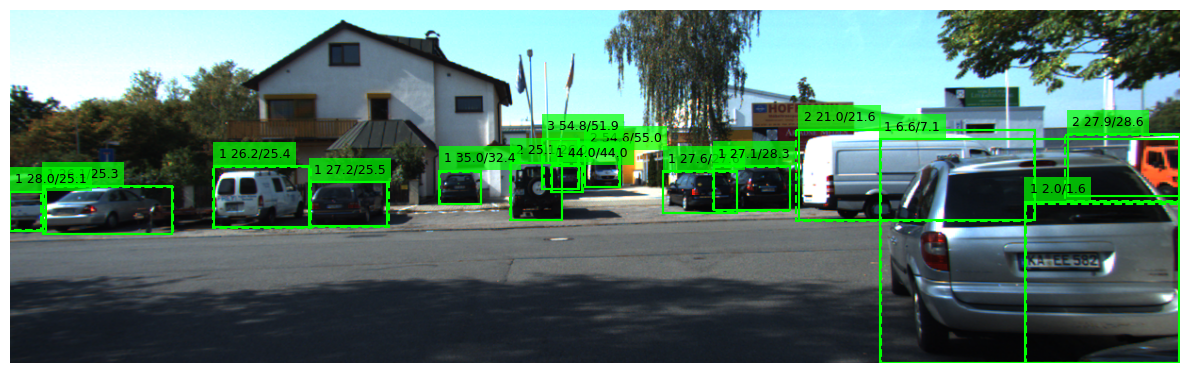



0: 224x640 1 0, 4 4s, 3 6s, 21.8ms
Speed: 2.8ms preprocess, 21.8ms inference, 8.8ms postprocess per image at shape (1, 3, 224, 640)

Image path: D:\UGM\tugas akhir\datasets\KITTI2017/images/train/000118.png
Num of predictions: 8
Num of ground truth: 7
[TP] Pred 0 <-> GT 2 | IoU: 0.946 | 6 | Dist: 41.0/41.2 (0.3%)
[TP] Pred 1 <-> GT 3 | IoU: 0.905 | 4 | Dist: 7.8/7.9 (1.6%)
[TP] Pred 2 <-> GT 1 | IoU: 0.920 | 6 | Dist: 40.7/38.3 (6.1%)
[TP] Pred 3 <-> GT 4 | IoU: 0.926 | 4 | Dist: 8.3/9.2 (9.8%)
[TP] Pred 4 <-> GT 5 | IoU: 0.898 | 4 | Dist: 15.2/13.0 (16.7%)
[TP] Pred 5 <-> GT 6 | IoU: 0.885 | 4 | Dist: 16.3/14.1 (16.2%)
[TP] Pred 6 <-> GT 0 | IoU: 0.918 | 0 | Dist: 30.2/27.6 (9.3%)
[FP] Pred 7 | 6


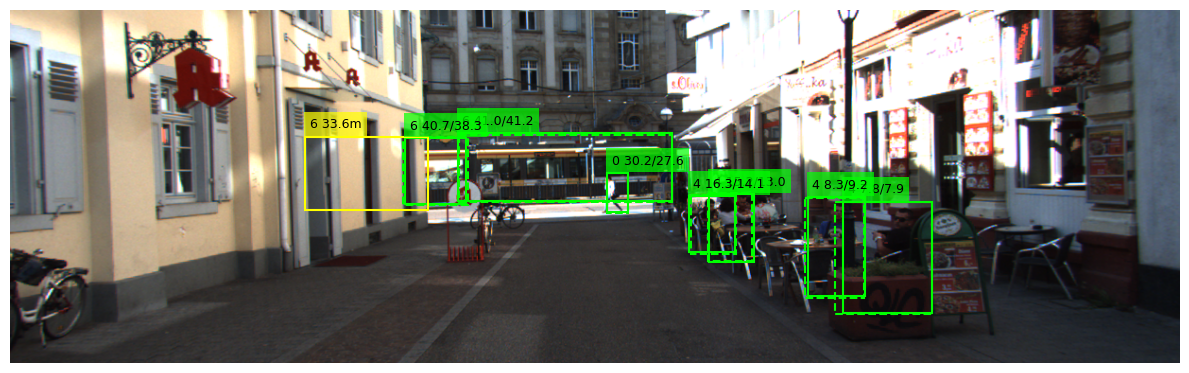



0: 224x640 6 1s, 1 6, 26.1ms
Speed: 2.7ms preprocess, 26.1ms inference, 30.9ms postprocess per image at shape (1, 3, 224, 640)

Image path: D:\UGM\tugas akhir\datasets\KITTI2017/images/train/000649.png
Num of predictions: 7
Num of ground truth: 7
[TP] Pred 0 <-> GT 0 | IoU: 0.959 | 1 | Dist: 11.6/11.6 (0.3%)
[TP] Pred 1 <-> GT 2 | IoU: 0.981 | 1 | Dist: 18.3/18.3 (0.1%)
[TP] Pred 2 <-> GT 4 | IoU: 0.952 | 1 | Dist: 27.6/28.2 (2.0%)
[TP] Pred 3 <-> GT 3 | IoU: 0.957 | 1 | Dist: 25.6/23.4 (9.5%)
[TP] Pred 4 <-> GT 1 | IoU: 0.920 | 6 | Dist: 79.1/78.8 (0.4%)
[TP] Pred 5 <-> GT 5 | IoU: 0.944 | 1 | Dist: 38.8/37.8 (2.6%)
[TP] Pred 6 <-> GT 6 | IoU: 0.957 | 1 | Dist: 43.3/43.0 (0.7%)


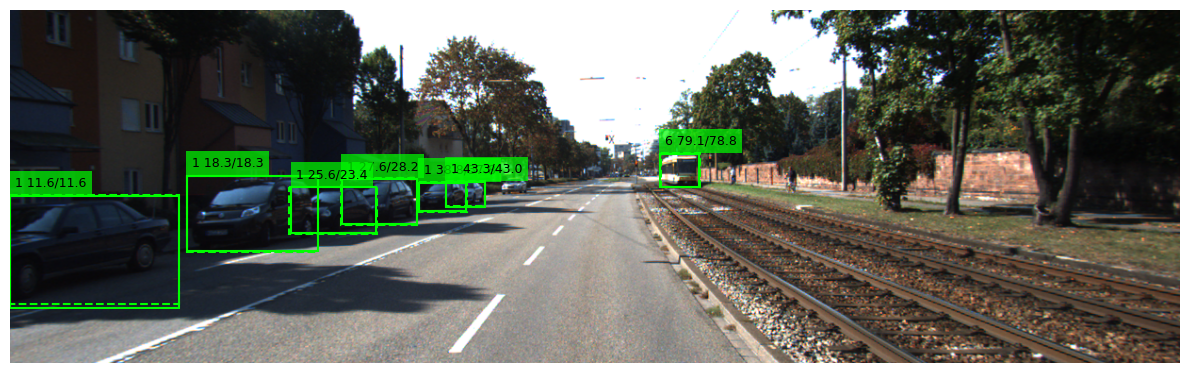

In [21]:
options = {
    "conf_thresh": 0.5,
    "iou_thresh": 0.5,
    "show_gt_dist": True,
    "euclidean_dist": False
}

"""
image examples:
- dist-yolo: train/000021, train/000113, train/000118, train/000649
- lateral objects: val/006072, val/006010, val/006081, val/006280
- false positives: val/006419, val/006128, val/006509, val/006770
- false negatives: val/007433, val/007429, val/007365, val/006646
"""

show_inference(dataset_path + "/images/train/000021.png", **options)
show_inference(dataset_path + "/images/train/000113.png", **options)
show_inference(dataset_path + "/images/train/000118.png", **options)
show_inference(dataset_path + "/images/train/000649.png", **options)